In [1]:
!git clone https://github.com/KillerStrike17/DeepLib

Cloning into 'DeepLib'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 30 (delta 6), reused 30 (delta 6), pack-reused 0
Receiving objects: 100% (30/30), 15.43 KiB | 5.14 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
!pip install torch-lr-finder

In [3]:
import torch
import matplotlib.pyplot as plt
torch.autograd.set_detect_anomaly(True)

torch.manual_seed(1)

batch_size = 512
class_map = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}
show_summary = True
show_dataset_analyze = True

In [4]:
# Load Network and Print Summary
from DeepLib.DeepLib.model import resnet
from DeepLib.DeepLib.utils.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()
use_cuda

torch.Size([1, 10])


True

In [5]:
device

device(type='cuda')

In [6]:
from DeepLib.DeepLib.dataset import get_loader
from DeepLib.DeepLib.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader('CIFAR10',get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


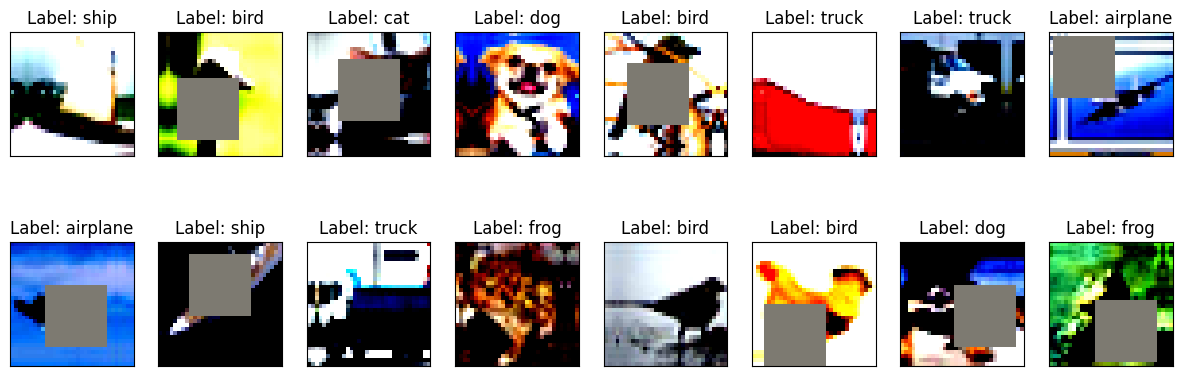

In [7]:
# Calculate Class Scale
from DeepLib.DeepLib.utils.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    # print_class_scale(train_loader, class_map)
    print_samples(train_loader,class_map)#

In [8]:
import time
import math

from DeepLib.DeepLib.backpropagation import train, test, get_sgd_optimizer,get_adam_optimizer
from DeepLib.DeepLib.utils.utils import initialize_weights
from DeepLib.DeepLib.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from DeepLib.DeepLib.training import Training

# bnmodel = CifarNet(norm='bn',base_channels=12).apply(initialize_weights).to(device)
model = resnet.ResNet18().apply(initialize_weights).to(device)
print_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.02E-02


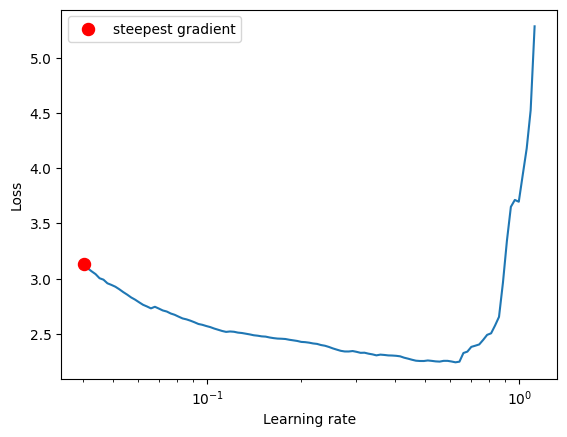

In [9]:
from torch_lr_finder import LRFinder

criterion = torch.nn.CrossEntropyLoss()
optimizer = get_adam_optimizer(model, lr=0.03, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode = "exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
# Train Params
epochs = 20
# lr =
max_lr = 4.02E-02
steps_per_epoch = len(train_loader)
dropout = False
momentum = 0.9
weight_decay = 1e-4

print("Using Device:", device)
print("Epochs:", epochs)
# print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

Using Device: cuda
Epochs: 20
Max Lr: 0.0402
Batch Size: 512
Dropout: False




In [11]:
pytorch_scheduler = one_cycle_lr_pt(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    anneal_strategy='linear'
)

In [12]:
trainer = Training(
    model,
    optimizer,
    pytorch_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    epochs,
    device,
    dropout
)

trainer.run()

| Epoch | LR       | Time    | TrainLoss | TrainCorrect | TrainAcc | ValLoss  | ValCorrect | ValAcc |
|     1 | 0.000402 | 00m 48s | 1.615961  |        20524 | 41.05  % | 2.339794 |       3771 | 37.71% |
|     2 | 0.008378 | 00m 50s | 1.283991  |        26816 | 53.63  % | 1.251196 |       5825 | 58.25% |
|     3 | 0.016354 | 00m 48s | 1.15028   |        29466 | 58.93  % | 1.358793 |       5342 | 53.42% |
|     4 | 0.024330 | 00m 48s | 1.071355  |        30924 | 61.85  % | 1.542268 |       5483 | 54.83% |
|     5 | 0.032306 | 00m 48s | 1.065605  |        31092 | 62.18  % | 1.698282 |       4541 | 45.41% |
|     6 | 0.040173 | 00m 48s | 1.029223  |        31822 | 63.64  % | 1.146925 |       6048 | 60.48% |
|     7 | 0.037493 | 00m 48s | 0.97693   |        32747 | 65.49  % | 2.835435 |       3603 | 36.03% |
|     8 | 0.034813 | 00m 47s | 0.932608  |        33629 | 67.26  % | 2.585027 |       4067 | 40.67% |
|     9 | 0.032133 | 00m 48s | 0.904178  |        34117 | 68.23  % | 1.110657 |   

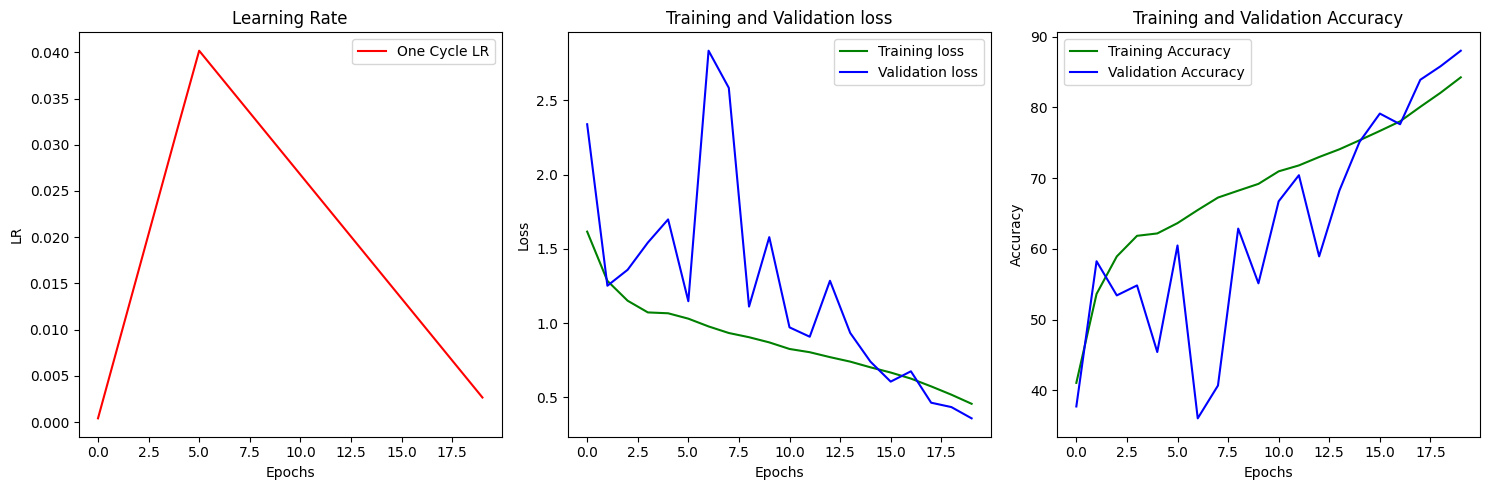

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Confusion matrix, without normalization
Total incorrect Predictions 1197


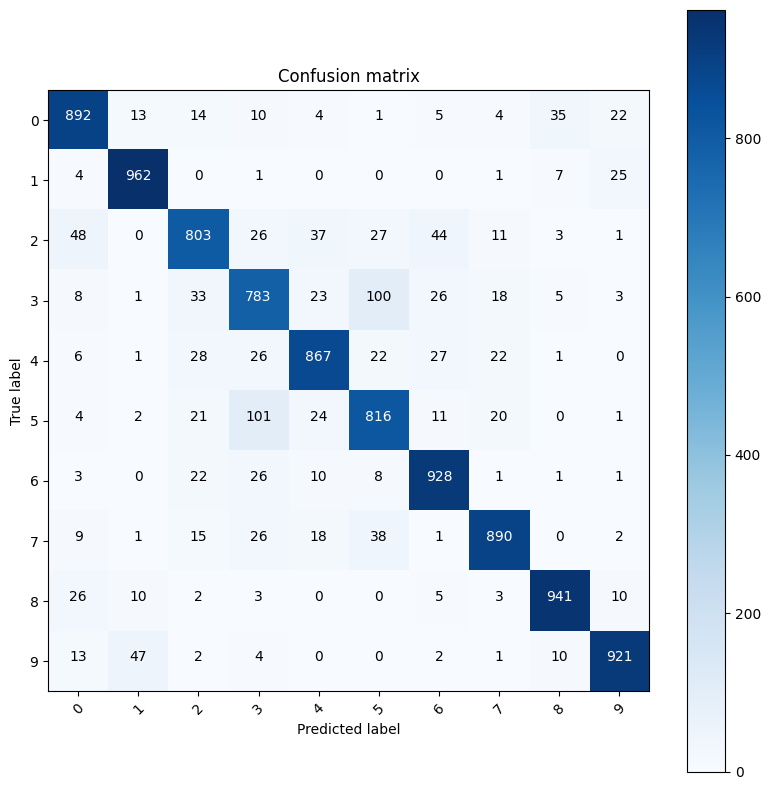

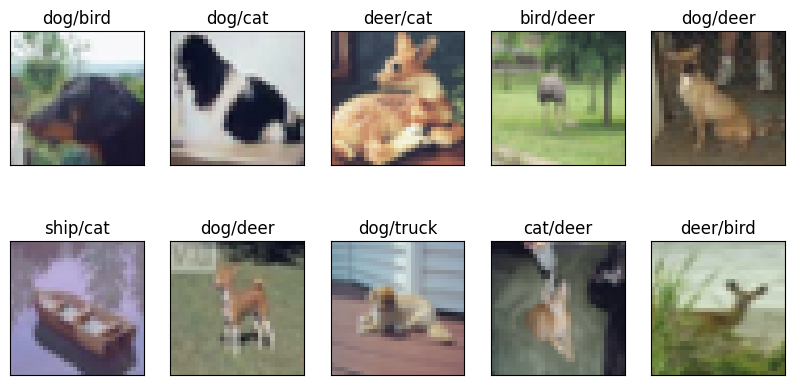

In [125]:
from DeepLib.DeepLib.utils.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

from DeepLib.DeepLib.utils.utils import get_all_predictions, prepare_confusion_matrix
from DeepLib.DeepLib.utils.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)


from DeepLib.DeepLib.utils.utils import get_predictions
from DeepLib.DeepLib.utils.visualize import plot_predictions

incorrect = get_predictions(model, test_loader, device,correct= False)
plot_predictions(incorrect, class_map,correct= False)

In [15]:
torch.save(model.state_dict(),"model.pt")

In [102]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38245 sha256=292865a84d85071a100c500f5b485f20fe59205ce90aa81bf03407f35fc19c33
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [4]:
from DeepLib.DeepLib.utils.utils import get_predictions
from DeepLib.DeepLib.utils.visualize import plot_predictions,plot_predictions_gradcam

In [117]:
correct = get_predictions(model, test_loader, device)

Total correct Predictions 8803


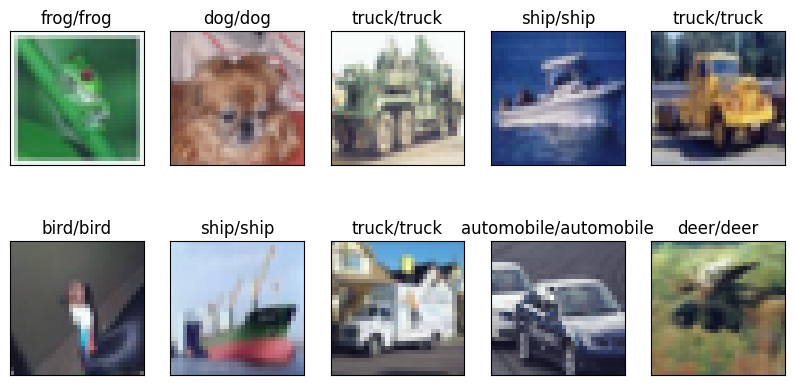

In [118]:
plot_predictions(correct, class_map)

In [119]:
target_layers = [model.layer3[-1]]

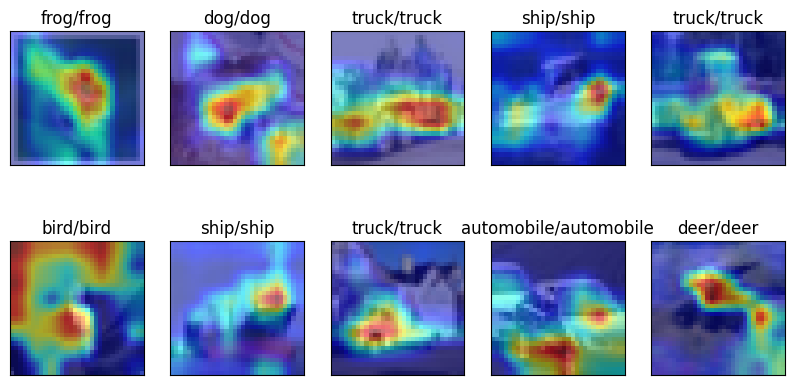

In [120]:
plot_predictions_gradcam(model,correct, class_map,target_layers,True)

In [121]:
incorrect = get_predictions(model, test_loader, device,correct=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Total incorrect Predictions 1197


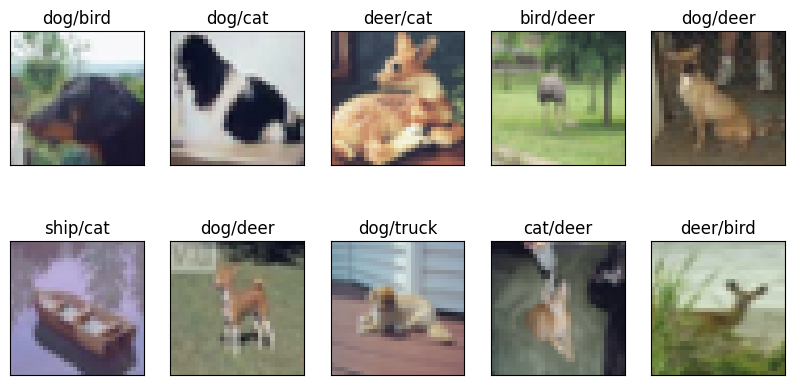

In [123]:
plot_predictions(incorrect, class_map,correct=False)

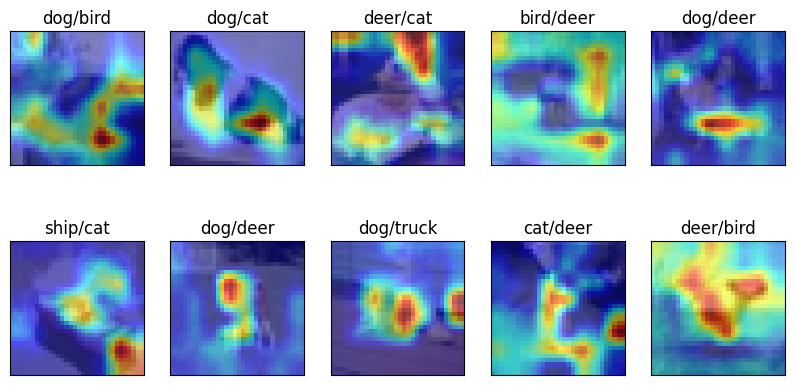

In [124]:
plot_predictions_gradcam(model,incorrect, class_map,target_layers,True)